# **Parzen**

In [ ]:
!pip install -U -q PyDrive
  
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1Ljk8zoMN_qvWfnK1v7qCPqoDoRmiacaf/view?usp=sharing'
link2 = 'https://drive.google.com/file/d/1hYwXfVf15FAIBLEbaeWaKP6H60rBRnoB/view?usp=sharing'
  
import pandas as pd
import numpy as np 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn import metrics
from scipy.spatial import distance
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt 

import joblib

import seaborn as sns
  
# to get the id part of the file
id = link.split("/")[-2]
id2 = link2.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_data.txt')  
  
dataset = pd.read_csv('train_data.txt', names=["id", "Jitter (local)", "Jitter (local, absolute)", 
                                               "Jitter (rap)", "Jitter (ppq5)", "Jitter (ddp)", 
                                               "Shimmer (local)", "Shimmer (local, dB)", "Shimmer (apq3)",
                                               "Shimmer (apq5)", "Shimmer (apq11)", "Shimmer (dda)",
                                               "AC", "NTH", "HTN", "Median pitch", "Mean pitch",
                                               "Standard deviation", "Minimum pitch", "Maximum pitch",
                                               "Number of pulses", "Number of periods", "Mean period",
                                               "Standard deviation of period", "Fraction of locally unvoiced frames",
                                               "Number of voice breaks", "Degree of voice breaks", "UPDRS", "class information"])

downloaded2 = drive.CreateFile({'id':id2}) 
downloaded2.GetContentFile('test_data.txt') 
dataset2 = pd.read_csv('test_data.txt', names=["id", "Jitter (local)", "Jitter (local, absolute)", 
                                               "Jitter (rap)", "Jitter (ppq5)", "Jitter (ddp)", 
                                               "Shimmer (local)", "Shimmer (local, dB)", "Shimmer (apq3)",
                                               "Shimmer (apq5)", "Shimmer (apq11)", "Shimmer (dda)",
                                               "AC", "NTH", "HTN", "Median pitch", "Mean pitch",
                                               "Standard deviation", "Minimum pitch", "Maximum pitch",
                                               "Number of pulses", "Number of periods", "Mean period",
                                               "Standard deviation of period", "Fraction of locally unvoiced frames",
                                               "Number of voice breaks", "Degree of voice breaks", "class information"])


X = dataset.drop(["class information", "UPDRS"], axis=1)
Y = dataset.drop(["id", "Jitter (local)", "Jitter (local, absolute)", 
                                               "Jitter (rap)", "Jitter (ppq5)", "Jitter (ddp)", 
                                               "Shimmer (local)", "Shimmer (local, dB)", "Shimmer (apq3)",
                                               "Shimmer (apq5)", "Shimmer (apq11)", "Shimmer (dda)",
                                               "AC", "NTH", "HTN", "Median pitch", "Mean pitch",
                                               "Standard deviation", "Minimum pitch", "Maximum pitch",
                                               "Number of pulses", "Number of periods", "Mean period",
                                               "Standard deviation of period", "Fraction of locally unvoiced frames",
                                               "Number of voice breaks", "Degree of voice breaks", "UPDRS"], axis=1)

X_to_test = dataset2.drop(["class information"], axis=1)
Y_to_test = dataset2.drop(["id", "Jitter (local)", "Jitter (local, absolute)", 
                                               "Jitter (rap)", "Jitter (ppq5)", "Jitter (ddp)", 
                                               "Shimmer (local)", "Shimmer (local, dB)", "Shimmer (apq3)",
                                               "Shimmer (apq5)", "Shimmer (apq11)", "Shimmer (dda)",
                                               "AC", "NTH", "HTN", "Median pitch", "Mean pitch",
                                               "Standard deviation", "Minimum pitch", "Maximum pitch",
                                               "Number of pulses", "Number of periods", "Mean period",
                                               "Standard deviation of period", "Fraction of locally unvoiced frames",
                                               "Number of voice breaks", "Degree of voice breaks"], axis=1)
X.head(20)

,id,Jitter (local),"Jitter (local, absolute)",Jitter (rap),Jitter (ppq5),Jitter (ddp),Shimmer (local),"Shimmer (local, dB)",Shimmer (apq3),Shimmer (apq5),Shimmer (apq11),Shimmer (dda),AC,NTH,HTN,Median pitch,Mean pitch,Standard deviation,Minimum pitch,Maximum pitch,Number of pulses,Number of periods,Mean period,Standard deviation of period,Fraction of locally unvoiced frames,Number of voice breaks,Degree of voice breaks
0,1,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,6.802,13.551,0.905905,0.119116,11.130,166.533,164.781,10.421,142.229,187.576,160,159,0.006065,0.000416,0.000,0,0.000
1,1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,7.194,6.175,0.951285,0.066758,17.403,195.252,193.289,14.773,159.515,234.505,170,169,0.005181,0.000403,2.247,0,0.000
2,1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,7.548,13.040,0.911508,0.109983,12.212,158.689,164.768,12.981,146.445,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178
3,1,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,16.779,15.789,0.901302,0.121982,11.384,201.997,203.471,10.853,182.713,220.230,94,92,0.004910,0.000320,0.000,0,0.000
4,1,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,12.823,9.307,0.856907,0.236831,10.653,211.887,208.440,11.499,182.821,225.162,117,114,0.004757,0.000380,18.182,1,13.318
5,1,2.470,0.000126,1.358,1.341,4.075,10.696,1.256,5.262,7.076,9.199,15.787,0.897708,0.152955,11.987,195.952,195.222,4.692,186.593,202.812,74,73,0.005118,0.000187,23.214,0,0.000
6,1,1.583,0.000082,0.768,0.864,2.303,9.057,1.070,3.794,5.158,7.670,11.381,0.935717,0.078695,13.705,195.535,192.316,7.512,177.299,200.638,85,84,0.005199,0.000245,4.348,0,0.000
7,1,1.920,0.000099,0.926,1.031,2.777,10.184,1.108,3.650,4.611,7.127,10.951,0.898598,0.147518,12.400,196.745,194.284,5.979,181.465,201.921,71,70,0.005137,0.000215,33.929,0,0.000
8,1,2.257,0.000119,1.239,1.530,3.716,8.044,0.877,3.449,4.239,7.654,10.346,0.877616,0.217236,12.831,191.345,185.423,21.878,86.139,210.523,107,104,0.005282,0.000348,15.152,2,9.810
9,1,1.594,0.000085,0.850,0.951,2.550,7.200,0.823,2.480,3.826,9.228,7.440,0.917596,0.112336,14.039,190.838,187.775,10.087,166.895,203.133,113,112,0.005335,0.000332,0.000,0,0.000


In [ ]:
for i in X.columns:
    X[i] = X[i].astype(float)

In [ ]:
for i in X_to_test.columns:
    X_to_test[i] = X_to_test[i].astype(float)

In [ ]:
Y['class information'] = Y['class information'].astype(int)

In [ ]:
Y_to_test['class information'] = Y_to_test['class information'].astype(int)

In [ ]:
def kernel_gaussiano(x):
    """Calcula el kernel gaussiano de x
    x: matriz/vector de numpy
    retorna: el valor de de kernel gaussiano
    """
    return np.exp((-0.5)*x**2)

def ParzenWindow(x,Data,h):
    """"ventana de parzen
    x: vector con representando una sola muestra
    Data: vector de muestras de entrenamiento
    h: ancho de la ventana de kernel
    retorna: el valor de ventana de parzen para una muestra
    """
    h = h
    Ns = Data.shape[0]
    suma = 0
    for k in range(Ns):
        u = distance.euclidean(x, Data[k,:])
        suma += kernel_gaussiano(u/h)
  
    return suma

In [ ]:
#Ejercicio de código
def parzenClass(X_train, Y_train, X_test, h):
    """ Funcion que implementa metodo de ventana de parzen para
        para clasificación
    X_train: es la matriz con las muestras de entrenamiento
    Y_train: es un vector con los valores de salida pra cada una de las muestras de entrenamiento
    X_test: es la matriz con las muestras de validación
    h (float): ancho de h de la ventana
    retorna: - las estimaciones del modelo parzen para el conjunto X_test 
              esta matriz debe tener un shape de [row/muestras de X_test]
             - las probabilidades de la vetana [row/muestras de X_test, número de clases]  
    """
        
    Yest = np.zeros(X_test.shape[0])
    clases = np.unique(Y_train)
    fds_matrix = np.zeros((X_test.shape[0], len(clases)))
    
    
    
    ## pista: recuerde el termino que acompaña al sumatoria (N)
    
    for n, sample in enumerate (X_test):
      valores = []
      etiquetas = []
      for label in clases:
          Y_train=Y_train.reshape(-1)
          etiquetas.append(X_train[Y_train==clases[label]])
          prob = ParzenWindow(X_test[n],etiquetas[label],h)/(len(etiquetas[label]))
          fds_matrix[n,label] = prob
          
          valores.append(prob)
          Yest[n] = valores.index(max(valores))

         
           
        
    
    

    #Debe retornar un vector que contenga las predicciones para cada una de las muestras en X_val, en el mismo orden.  
    return Yest, fds_matrix

In [ ]:
#ejercicio de codigo
def experimentarParzen (X, Y, hs):
    """Función que realiza los experimentos con knn usando
       una estrategia de validacion entrenamiento y pruebas
    X: matriz de numpy conjunto con muestras y caracteristicas
    Y: vector de numpy con los valores de las etiquetas
    ks: List[int/float] lista con los valores de k-vecinos a usar
    retorna: dataframe con los resultados, debe contener las siguientes columnas:
        - el ancho de ventana, el error medio de prueba, la desviacion estandar del error
    """
    
    Pacientes = X['id'].values
    Xv = X.values
    y = Y['class information'].values
    train_inds, test_inds = next(GroupKFold(n_splits = 5).split(Xv, y, Pacientes))
    
    gkf = GroupKFold(n_splits = 5)
    resultados = pd.DataFrame()
    idx = 0
    
    Y = Y.values
    for h in hs:
        # lista para almacenar los errores de cada iteración
        # de la validación
        error_temp = []
        
        
        for train_inds, test_inds in gkf.split(X, y, Pacientes):
            
           
            sc_X = StandardScaler()   
            Xtrain = sc_X.fit_transform(Xv[train_inds,:])
            Xtest = sc_X.transform(Xv[test_inds,:])
            Ytest = y[test_inds]
            Ytrain = y[train_inds]
    
            
            
            Yest, probabilidades = parzenClass(Xtrain, Ytrain, Xtest, h)
            errorTest = metrics.accuracy_score(Yest, Ytest)
            error_temp.append(errorTest)
    
        resultados.loc[idx,'bandwidth'] = h 
        resultados.loc[idx,'accuracy prom'] = np.mean(error_temp)
        resultados.loc[idx,'standard deviation'] = np.std(error_temp)
        idx+=1
    return (resultados, Yest)

In [ ]:

hs = [0.05, 0.1, 0.5, 1, 2, 5, 10]
experimentos_parzen, y_est = experimentarParzen(X, Y, hs)
experimentos_parzen

,bandwidth,accuracy prom,standard deviation
0,0.05,0.693269,0.058992
1,0.10,0.788462,0.033170
2,0.50,0.814423,0.016261
3,1.00,0.831731,0.048269
4,2.00,0.798077,0.073982
5,5.00,0.739423,0.099295
6,10.00,0.676923,0.113665


In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size = 0.20, random_state = 5, shuffle=True)
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
y_train = y_train.values
Yest, probabilidades = parzenClass(X_train, y_train, X_test, 1.00)
accuracyPz = metrics.accuracy_score(Yest, y_test)
precisionPz = metrics.precision_score(Yest, y_test)
recallPz = metrics. recall_score(Yest, y_test)

table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Ventana de parzen': [accuracyPz, precisionPz, recallPz]
    })
table

,Metric,Ventana de parzen
0,Accuracy,0.903846
1,Precision,0.908257
2,Recall,0.908257


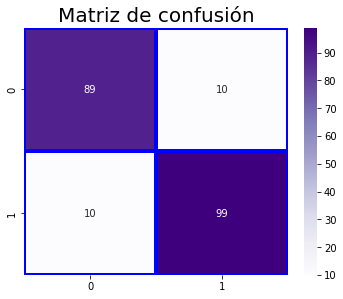

In [ ]:
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(metrics.confusion_matrix(y_test, Yest),annot=True,fmt="d",linecolor="blue",linewidths=3,cmap='Purples')
plt.title("Matriz de confusión",fontsize=20)
matriss = metrics.confusion_matrix(y_test,Yest,normalize='true')

In [ ]:
Yest, probabilidades = parzenClass(X.values, Y.values, X_to_test.values, 1.00)
accuracyPz = metrics.accuracy_score(Y_to_test, Yest)
precisionPz = metrics.precision_score(Y_to_test, Y_to_test)
recallPz = metrics. recall_score(Y_to_test, Yest)

table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Ventana de parzen': [accuracyPz, precisionPz, recallPz]
    })
table

,Metric,Ventana de parzen
0,Accuracy,0.357143
1,Precision,1.000000
2,Recall,0.357143
